In [1]:
import sys ; sys.path.append('../')
import torch.optim as optim
import torch
import seaborn as sb
import pytorch_lightning as pl
import numpy as np
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import time

from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from learn_KKL.luenberger_observerV3 import LuenbergerObserver
from learn_KKL.system import RevDuffing
from learn_KKL.learnerV3 import Learner
from learn_KKL.raffinement_dimN import *
#sb.set_style('whitegrid')
import matplotlib.pyplot as plt

In [2]:
# Set up the system
system = RevDuffing()
# Instantiate the observer
observer = LuenbergerObserver(dim_x=2, dim_y=1, method='Supervised', recon_lambda=0.8, wc=0.03,
                              activation=torch.nn.SiLU())
observer.set_dynamics(system)
# Generate initial dataset
data,grid = observer.generate_data_svl(np.array([[-1, 1.], [-1., 1.]]), [30,30],
                                  method='adaptative')

In [4]:
# Generate the test dataset
data_test,grid_test = observer.generate_data_svl(np.array([[-1, 1.], [-1., 1.]]), [40,40],
                                  method='adaptative')

In [5]:
data_init, val_data_init = train_test_split(data, test_size=0.3, shuffle=True)
data_init.shape

torch.Size([630, 5])

In [6]:
# Train the inverse transformation using pytorch-lightning and the learner class
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T_star = Learner(observer=observer, system=system, training_data=data_init,
                         validation_data=val_data_init, axe=0, method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)

# Define logger and checkpointing
logger1 = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger1,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T_star)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_44/tb_logs\lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.0 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_44


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:495: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the nu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.


Validation: 0it [00:00, ?it/s]

Epoch 00011: reducing learning rate of group 0 to 5.0000e-06.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 5.0000e-07.


In [7]:
#predict x1
x1 = data[:,0]
x1 = torch.as_tensor(x1)
z = data[:,2:5]
z = torch.as_tensor(z)

x1_hat = observer.decoder(z).detach()
error1 = torch.abs(x1-x1_hat[:,0])
rmse = torch.sqrt((error1**2).sum())
print("RMSE : ",rmse)

RMSE :  tensor(6.5112)


In [8]:
# Train the inverse transformation using pytorch-lightning and the learner class
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T_star = Learner(observer=observer, system=system, training_data=data_init,
                         validation_data=val_data_init, axe=1, method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)

# Define logger and checkpointing
logger1 = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger1,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T_star)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_45/tb_logs\lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.0 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_45


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [9]:
# Compute the prediction error over the initial dataset - The error is to determine the refinement criterium
x2 = data[:,1]
x2 = torch.as_tensor(x2)
z = data[:,2:5]
z = torch.as_tensor(z)

x2_hat = observer.decoder(z).detach()
error2 = torch.abs(x2-x2_hat[:,0])
rmse2 = torch.sqrt((error2**2).sum())
print("RMSE : ",rmse)

RMSE :  tensor(6.5112)


C:\Users\pchauris\AppData\Local\Temp\ipykernel_8472\181622122.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(p1,ax=ax1)
C:\Users\pchauris\AppData\Local\Temp\ipykernel_8472\181622122.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(p2,ax=ax2)


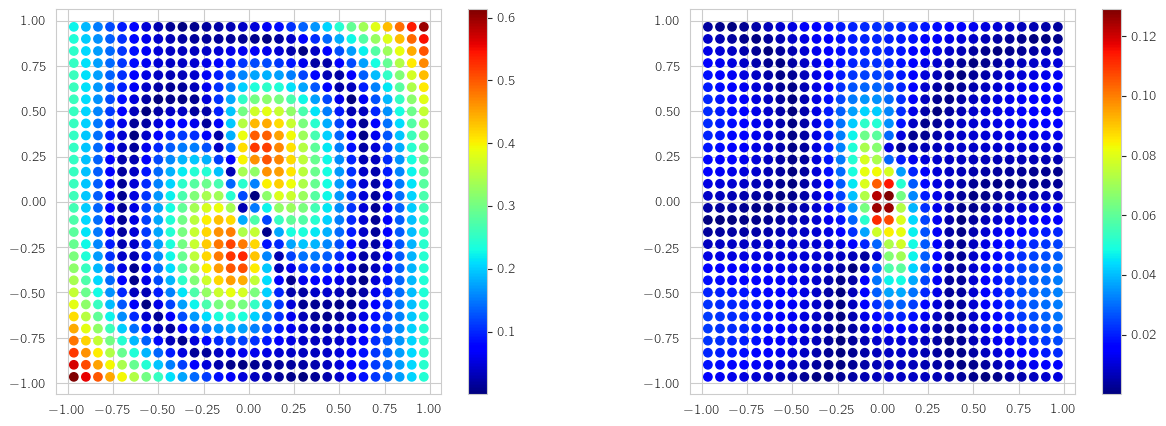

In [11]:
im,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
p1 = ax1.scatter(x1,x2,c=error1,cmap='jet')
ax1.axis('square')
im.colorbar(p1,ax=ax1)
p2 = ax2.scatter(x1,x2,c=error2,cmap='jet')
ax2.axis('square')
im.colorbar(p2,ax=ax2)
plt.show()

In [12]:
# refine the initial dataset with the criteria
critere1 = error1
critere2 = error2
data1,grid1 = observer.raffine_grid(grid,critere1)
data2,grid2 = observer.raffine_grid(grid,critere2)

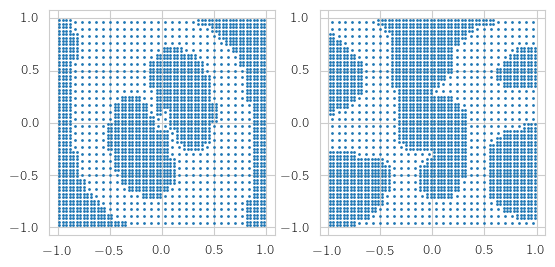

In [17]:
_,(ax1,ax2) = plt.subplots(1,2)
ax1.scatter(coordinate(grid1)[:,0],coordinate(grid1)[:,1],s=1)
ax2.scatter(coordinate(grid2)[:,0],coordinate(grid2)[:,1],s=1)
ax1.axis('square')
ax2.axis('square')
plt.show()

In [18]:
data_1, val_data_1 = train_test_split(data1, test_size=0.3, shuffle=True)
data_2, val_data_2 = train_test_split(data2, test_size=0.3, shuffle=True)

In [19]:
# Train the inverse transformation using pytorch-lightning and the learner class
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T_star = Learner(observer=observer, system=system, training_data=data_1,
                         validation_data=val_data_1, axe=0, method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)

# Define logger and checkpointing
logger1 = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger1,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T_star)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_46/tb_logs\lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.0 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_46


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:495: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the nu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 5.0000e-05.


Validation: 0it [00:00, ?it/s]

In [20]:
#predict x1
x1 = data_test[:,0]
x1 = torch.as_tensor(x1)
z = data_test[:,2:5]
z = torch.as_tensor(z)

x1_hat = observer.decoder(z).detach()
error1 = torch.abs(x1-x1_hat[:,0])
rmse = torch.sqrt((error1**2).sum())
print("RMSE : ",rmse)

RMSE :  tensor(7.6365)


In [21]:
# Train the inverse transformation using pytorch-lightning and the learner class
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T_star = Learner(observer=observer, system=system, training_data=data_2,
                         validation_data=val_data_2, axe=1, method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)

# Define logger and checkpointing
logger1 = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger1,
    log_every_n_steps=1, check_val_every_n_epoch=3)

trainer.fit(learner_T_star)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_47/tb_logs\lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.0 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_47


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:495: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the nu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 5.0000e-05.


Validation: 0it [00:00, ?it/s]

Epoch 00010: reducing learning rate of group 0 to 5.0000e-06.


Validation: 0it [00:00, ?it/s]

In [22]:
trainer.fit(learner_T_star)
#predict x1
x2 = data_test[:,1]
x2 = torch.as_tensor(x2)
z = data_test[:,2:5]
z = torch.as_tensor(z)

x2_hat = observer.decoder(z).detach()
error2 = torch.abs(x2 - x2_hat[:, 0])
rmse = torch.sqrt((error2 ** 2).sum())
print("RMSE : ", rmse)

C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:611: UserWarning: Checkpoint directory C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\../jupyter_notebooks/runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_47/tb_logs\lightning_logs\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.0 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

RMSE :  tensor(0.9077)


C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:495: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


C:\Users\pchauris\AppData\Local\Temp\ipykernel_8472\3512968931.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(p1,ax=ax1)
C:\Users\pchauris\AppData\Local\Temp\ipykernel_8472\3512968931.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(p2,ax=ax2)


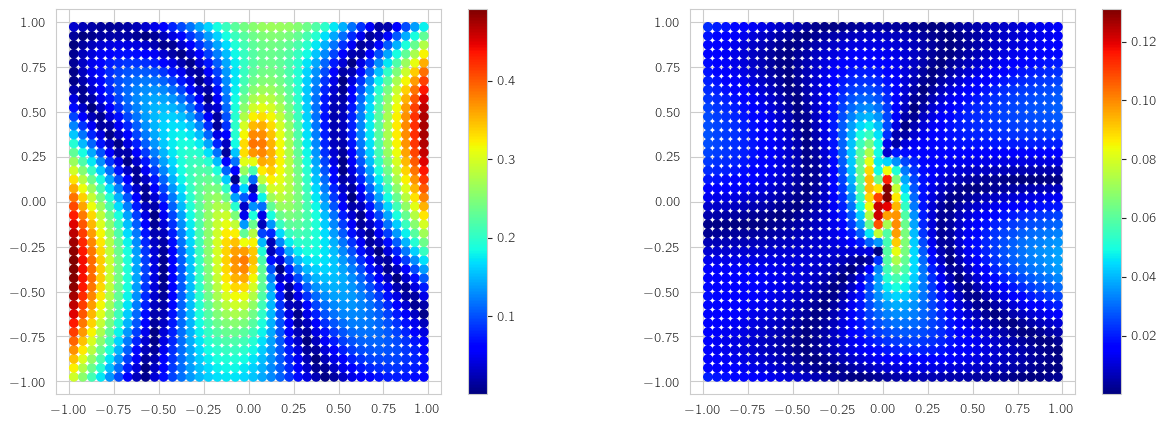

In [23]:
im,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
p1 = ax1.scatter(x1,x2,c=error1,cmap='jet')
ax1.axis('square')
im.colorbar(p1,ax=ax1)
p2 = ax2.scatter(x1,x2,c=error2,cmap='jet')
ax2.axis('square')
im.colorbar(p2,ax=ax2)
plt.show()